In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import copy
import csv

# configuration
start_post = 0
end_post = 5

print("imported modules")

imported modules


In [2]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


In [65]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'POS': 'NOUN', 'OP': '+'},
           {'POS': 'NOUN', 'OP': '?'}
          ]


word_set = set()
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'

matcher.add("match_topic1", [topic_pattern1])

questions_df = pd.DataFrame(stack_posts[start_post:end_post])
questions_df = questions_df.drop_duplicates(["QuestionId"])

topic_counter = Counter()

for question in questions_df["QuestionBody"][start_post:end_post]:
    text = re.sub(regex_pattern, '', question, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)    
    
    doc = nlp(text)    
    
    matches = matcher(doc)
    
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = filter_spans(span_list)    
    
    ##### changed
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.01) #, vocabulary=filtered_spans) #, max_features=3
    text_vectorizer = vectorizer.fit_transform([text])
    
    relevant_words = []
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_bigger_than = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= 0.5]
    relevant_words.append(feature_array[tfidf_bigger_than])  
        
    
    
        
    for word in relevant_words[0]:          
        for span in filtered_spans:            
            if word in span.text:    
                topic_counter[span.lemma_] += 1
    print(topic_counter)
    break
    #####   
                
#print("finished questions")
#for answer in stack_posts["AnswerBody"][start_post:end_post]:
#    text = re.sub(regex_pattern, '', answer, flags=re.I)
#    text = re.sub('\(|\)', ' ', text, flags=re.I)    
    
#    doc = nlp(text)    
    
#    matches = matcher(doc)
    
#    span_list = [doc[match[1]:match[2]] for match in matches]
#    filtered_spans = filter_spans(span_list)
    
            
#    for span in filtered_spans:
#        topic_counter[span.lemma_] += 1


print("finished answers")

Counter({'diagram comparison': 1, 'diagram': 1})
finished answers


Text(0, 0.5, 'Häufigkeit')

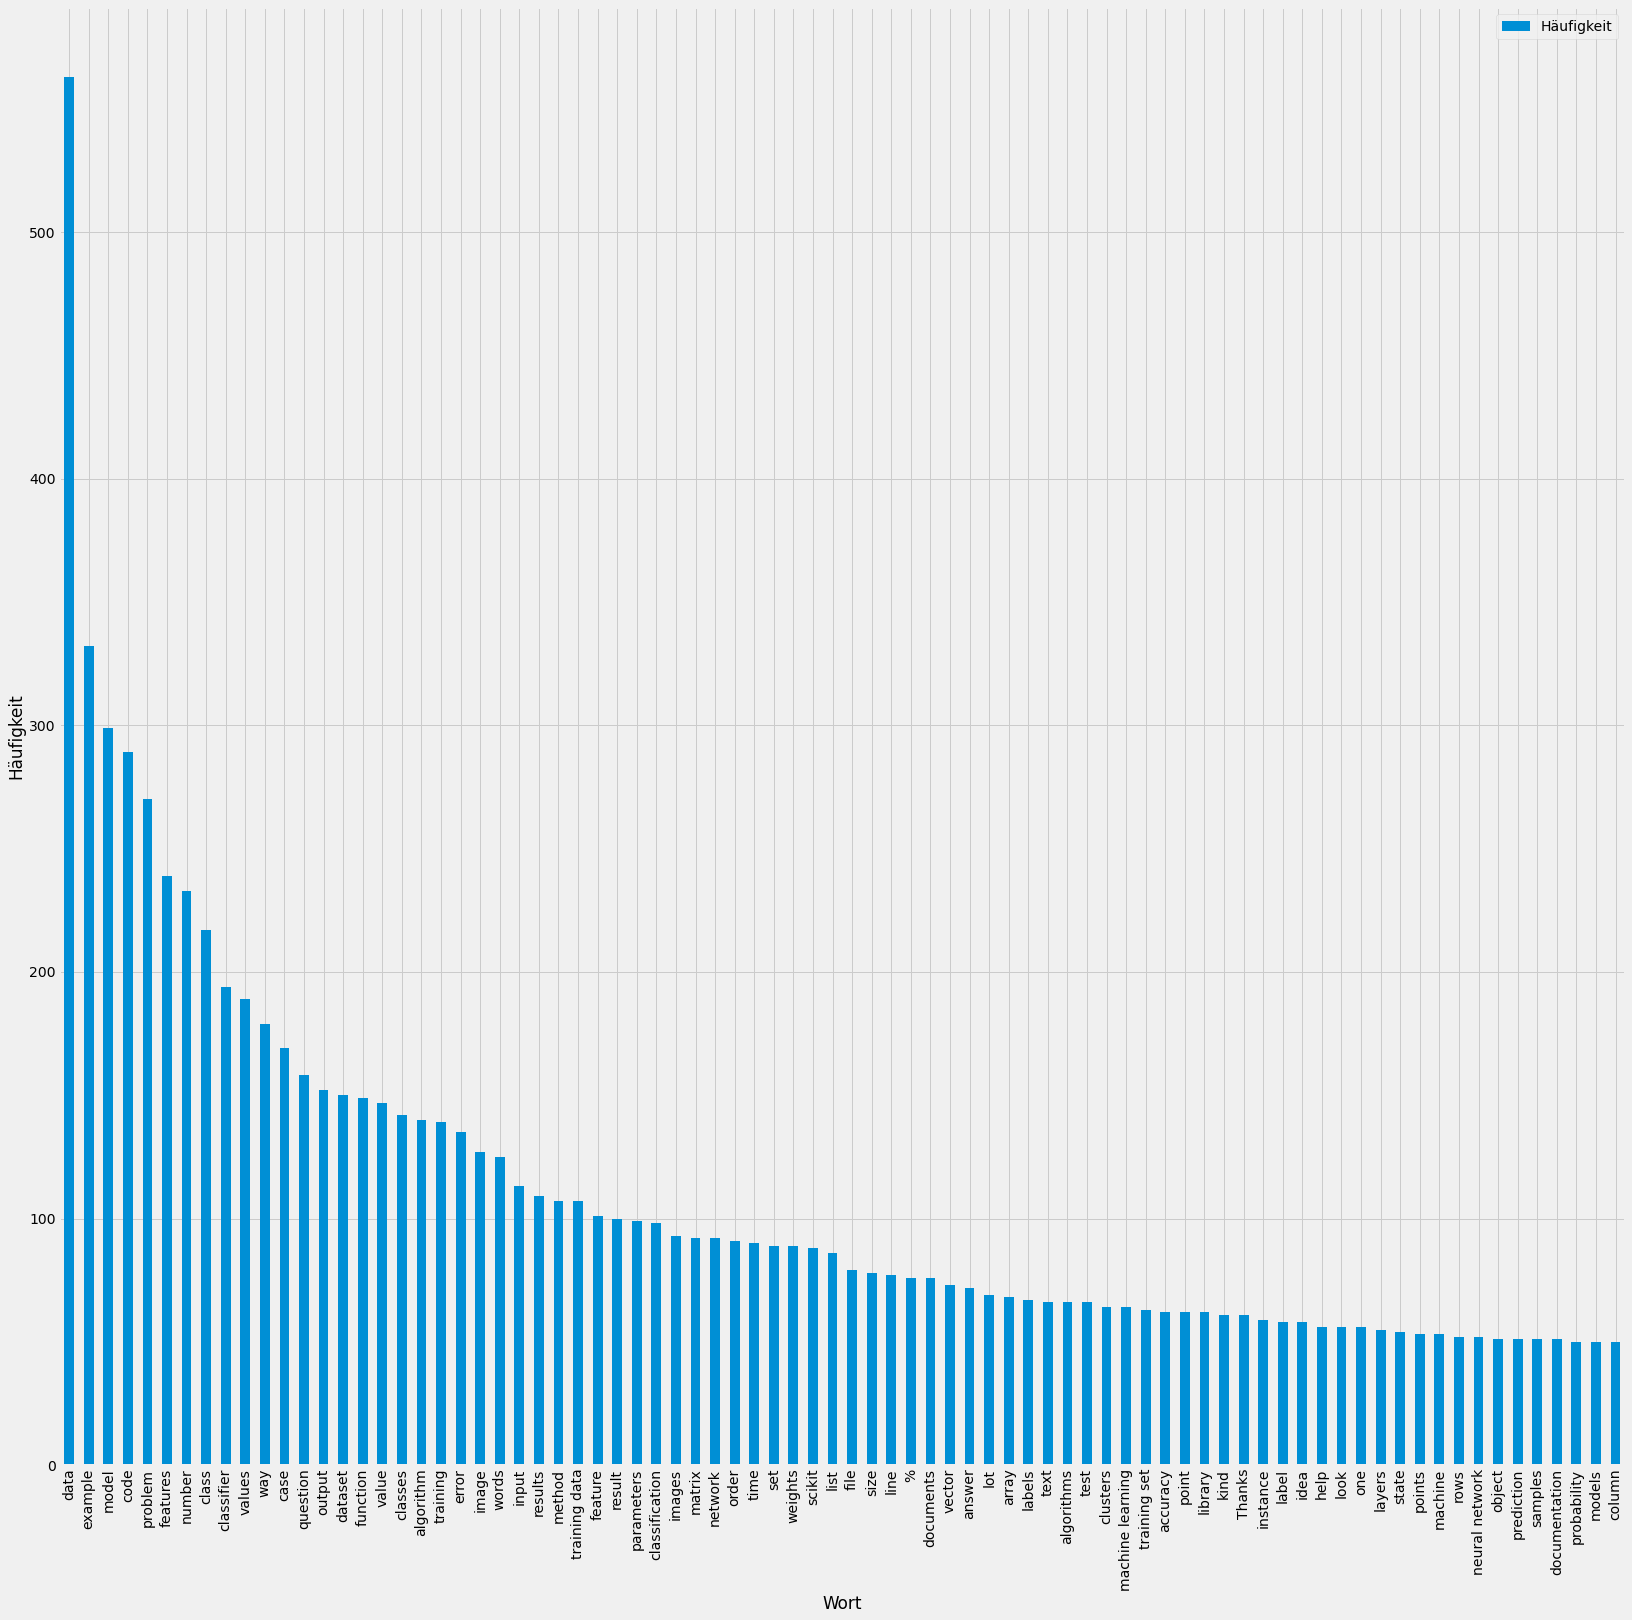

In [54]:
bigger_than_x_counter = Counter({k: c for k,c in topic_counter.items() if c >= 50})
sorted_counter = bigger_than_x_counter.most_common()
df = pd.DataFrame.from_dict(bigger_than_x_counter, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False)

plt.style.use('fivethirtyeight')

figure = df.plot(kind = 'bar', figsize=(25, 25))
figure.set_xlabel("Wort")
figure.set_ylabel("Häufigkeit")

In [17]:
Counter({k: c/topic_counter_sum*100 for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True)})

Counter({'datum': 1.5202914939062697,
         'model': 1.2205409868432862,
         'example': 1.1696851123914827,
         'feature': 1.0314767947636398,
         'code': 0.9231836974015639,
         'class': 0.9207904797803026,
         'problem': 0.8795074758135445,
         'value': 0.8519854731690389,
         'number': 0.7245466348368723,
         'case': 0.6282196255811031,
         'output': 0.6078772758003818,
         'function': 0.5917230568568677,
         'way': 0.588731534830291,
         'image': 0.5582180101592088,
         'result': 0.5504400528901094,
         'algorithm': 0.5456536176475868,
         'classifier': 0.5348841383519107,
         'input': 0.5223197458402886,
         'error': 0.521123137029658,
         'dataset': 0.4906096123585758,
         'question': 0.4870197859266838,
         'training': 0.4355656070695648,
         'weight': 0.42599273658451947,
         'label': 0.4253944321792042,
         'parameter': 0.4206079969366815,
         'point': 0.4

In [14]:
topic_counter_sum = sum(topic_counter.values())
relative_counter = Counter({k: c/topic_counter_sum*100 for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=False)})


#keys = list(relative_counter.keys())
#values = relative_counter.values()


#fig, ax = plt.subplots(figsize=(20,20))
#plt.xticks(np.arange(min(values), max(values)+1, 50.0))
#ax.xaxis.tick_top()
#ax.barh(keys, values)


Counter({'diagram comparison': 0.0005983044053153363,
         'flow chart': 0.0005983044053153363,
         'various scale': 0.0005983044053153363,
         'very basic': 0.0005983044053153363,
         'counter example': 0.0005983044053153363,
         'proper classifier': 0.0005983044053153363,
         'word,?editmy test file': 0.0005983044053153363,
         'noun word': 0.0005983044053153363,
         'restful part': 0.0005983044053153363,
         'app datum': 0.0005983044053153363,
         'redeploy': 0.0005983044053153363,
         'english digit classification': 0.0005983044053153363,
         '% number': 0.0005983044053153363,
         'enough experience': 0.0005983044053153363,
         'overoptimistic data scientist': 0.0005983044053153363,
         'wrong model': 0.0005983044053153363,
         'particular evaluation strategy': 0.0005983044053153363,
         'simple program': 0.0005983044053153363,
         'random forest curve': 0.0005983044053153363,
         'kind re

In [13]:
relative_counter

Counter({'diagram comparison': 5.9830440531533635e-06,
         'flow chart': 5.9830440531533635e-06,
         'various scale': 5.9830440531533635e-06,
         'very basic': 5.9830440531533635e-06,
         'counter example': 5.9830440531533635e-06,
         'proper classifier': 5.9830440531533635e-06,
         'word,?editmy test file': 5.9830440531533635e-06,
         'noun word': 5.9830440531533635e-06,
         'restful part': 5.9830440531533635e-06,
         'app datum': 5.9830440531533635e-06,
         'redeploy': 5.9830440531533635e-06,
         'english digit classification': 5.9830440531533635e-06,
         '% number': 5.9830440531533635e-06,
         'enough experience': 5.9830440531533635e-06,
         'overoptimistic data scientist': 5.9830440531533635e-06,
         'wrong model': 5.9830440531533635e-06,
         'particular evaluation strategy': 5.9830440531533635e-06,
         'simple program': 5.9830440531533635e-06,
         'random forest curve': 5.9830440531533635e-06

<BarContainer object of 2253 artists>

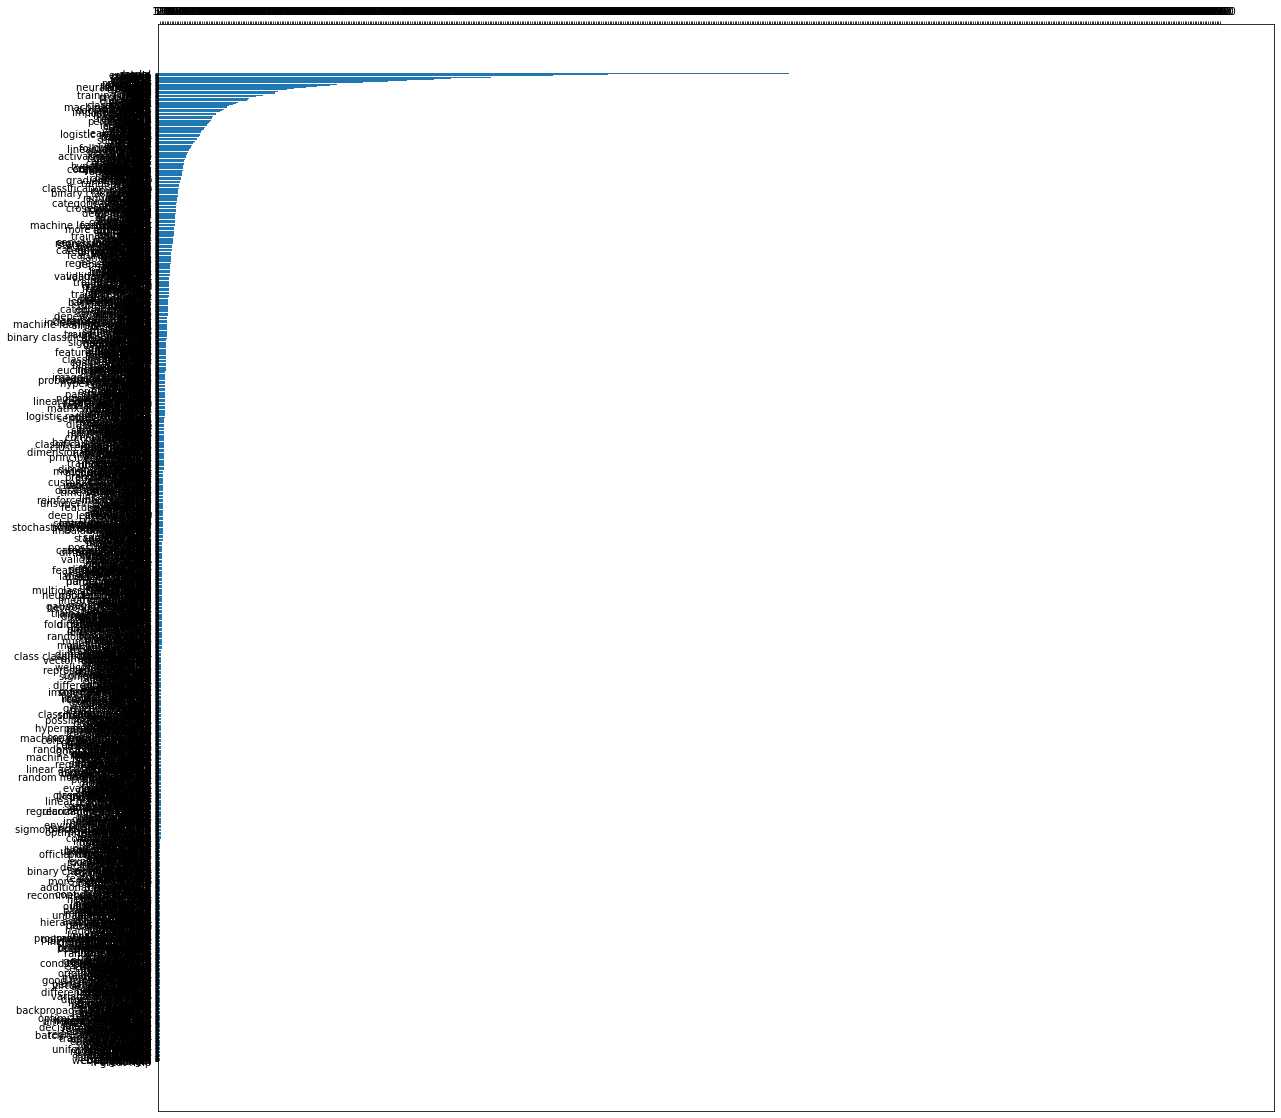

In [14]:
bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=False) if c >= 50})



keys = list(bigger_than_x_counter.keys())
values = bigger_than_x_counter.values()


fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(np.arange(min(values), max(values)+1, 50.0))
ax.xaxis.tick_top()
ax.barh(keys, values)

